In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as spy
import networkx as nx
from   sklearn.datasets import make_s_curve
import seaborn as sns
import time
import pickle

d:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [9]:
import networkx as nx
import faiss
import time
import scipy as spy
from datasketch import MinHash
from datasketch import WeightedMinHashGenerator
import copy
from scipy.optimize import curve_fit
import statsmodels.api as sm
from scipy.stats import ks_2samp





def Random_Fourier_Feature_Hashing(X,TargetDim):
    N = np.size(X,0)
    d = np.size(X,1)
    W = np.random.normal(loc=0, scale=1, size=(d, TargetDim))
    b = np.random.uniform(0, 2*np.pi, size=TargetDim)
    B = np.repeat(b[:, np.newaxis], N, axis=1).T
    Z = 1/2* (1+ np.sign(np.cos(X @ W + B)))
    Z = np.uint8(Z)
    return Z

def Random_Cauchy_Feature_Hashing(X,TargetDim):
    N = np.size(X,0)
    d = np.size(X,1)
    W = spy.stats.cauchy.rvs(loc=0, scale=1, size=(d, TargetDim))
    b = np.random.uniform(0, 2*np.pi, size=TargetDim)
    B = np.repeat(b[:, np.newaxis], N, axis=1).T
    Z = 1/2* (1+ np.sign(np.cos(X @ W + B)))
    Z = np.uint8(Z)
    return Z

def Random_Hyperplane_Hashing(X,TargetDim):
    d = np.size(X,1)
    W = np.random.normal(loc=0, scale=1, size=(d, TargetDim))
    Z = 1/2* (1+ np.sign(X @ W))
    Z = np.uint8(Z)
    return Z


def Weighted_Min_Hashing(X,TargetDim):
    dim=len(X[0])
    wmg = WeightedMinHashGenerator(dim=dim,sample_size=TargetDim)
    Z=np.zeros((len(X),TargetDim))
    for ID1 in range(len(X)):
        wm = wmg.minhash(X[ID1]).digest()
        Z[ID1,:]=wm[:,0]*dim+wm[:,1]
    return Z


def Random_Min_Hashing(X,TargetDim):
    Z=np.zeros((len(X),TargetDim))
    for ID1 in range(len(X)):
        Hashing_Code=MinHash(num_perm=TargetDim)
        Hashing_Code.update_batch(X[ID1])
        Z[ID1,:]=Hashing_Code.hashvalues
    return Z

def Neighbor_Generator(X,UnitNum):
    Y=[]
    for Unit in range(UnitNum):
        Neighbors = [Unit] + list(X.neighbors(Unit))
        Y.append(np.array(Neighbors))
    return Y


def Normalization_Function(X_Current,Method_Type):
    if Method_Type=="Linear_Kernel":
        Normalized_X=X_Current-np.mean(X_Current,axis=1).reshape(np.size(X_Current,0),1)
    elif Method_Type=="Gaussian_Kernel":
        Normalized_X=X_Current-np.mean(X_Current,axis=1).reshape(np.size(X_Current,0),1)
        Std=np.std(Normalized_X,axis=1).reshape(np.size(Normalized_X,0),1)
        Normalized_X=np.divide(Normalized_X,Std,out=Normalized_X,where=Std!=0)
    elif Method_Type=="Cauchy_Kernel":
        Normalized_X=X_Current-np.min(X_Current,axis=1).reshape(np.size(X_Current,0),1)
        SumV=np.sum(Normalized_X,axis=1).reshape(np.size(Normalized_X,0),1)
        Normalized_X=np.divide(Normalized_X,SumV,out=Normalized_X,where=SumV!=0)
    return Normalized_X

def Binary_Hashing_Index(Z):
    if np.size(Z,0)<=50000:
        Dim=8*np.size(Z,1)
        Index = faiss.IndexBinaryFlat(Dim)
        Index.nprobe = 2
    elif (np.size(Z,0)>50000)&(np.size(Z,0)<=500000):
        Dim=8*np.size(Z,1)
        Index = faiss.IndexBinaryHash(Dim,Dim)
        Index.nprobe = 2
    elif np.size(Z,0)>500000:
        Dim=8*np.size(Z,1)
        Index = faiss.IndexBinaryHash(Dim,int(np.max([np.min([np.ceil(Dim/100),32]),16])))
        Index.nprobe = 2
    return Index


def KNN_with_Hashing_Index(Z):
    StartT=time.time()
    Index=Binary_Hashing_Index(Z)
    Index.add(Z)
    Num_neighbors=2
    D, I = Index.search(Z, Num_neighbors)
    EndT=time.time()
    print(['KNN search costs-', EndT-StartT])
    return D,I

def Hashing_Function(Normalized_X,TargetDim,Method_Type):
    if Method_Type=="Linear_Kernel":
        Z=Random_Hyperplane_Hashing(Normalized_X,TargetDim)
    elif Method_Type=="Gaussian_Kernel":
        Z=Random_Fourier_Feature_Hashing(Normalized_X,TargetDim)
    elif Method_Type=="Cauchy_Kernel":
        Z=Random_Cauchy_Feature_Hashing(Normalized_X,TargetDim)
    return Z

def Renormalization_Function(X_Current,TargetDim,Iter,Method_Type):
    Normalized_X=Normalization_Function(X_Current,Method_Type)
    Z=Hashing_Function(Normalized_X,TargetDim,Method_Type)
    _,I=KNN_with_Hashing_Index(Z)
    G = nx.empty_graph(np.size(I,0))
    Edge = np.vstack((np.arange(0, np.size(I, 0)), I[:,1])).T
    G.add_edges_from(Edge)
    Clusters=[list(c) for c in list(nx.connected_components(G))]
    ClusterNum=nx.number_connected_components(G)
    print(['There are', ClusterNum, 'macro-units after', Iter+1, 'times of renormalization'])
    X_New=np.zeros((ClusterNum, np.size(X_Current,1)))
    Corase_ID = []
    for ID1 in range(ClusterNum):
        X_New[ID1,:]=np.sum(X_Current[Clusters[ID1],:],axis=0)
        Corase_ID.append(Clusters[ID1])
    return X_New, Corase_ID

def Network_Renormalization_Function(X_Current,TargetDim,Iter,Method_Type,Weighted): 
    UnitNum=nx.number_of_nodes(X_Current)
    if Weighted:
        Z=Weighted_Min_Hashing(nx.adjacency_matrix(X_Current).toarray(),TargetDim)
    else:
        Y=Neighbor_Generator(X_Current,UnitNum)
        Z=Random_Min_Hashing(Y,TargetDim)
    Z=Hashing_Function(Z,TargetDim,Method_Type)
    _,I=KNN_with_Hashing_Index(Z)
    G = nx.empty_graph(np.size(I,0))
    Edge = np.vstack((np.arange(0, np.size(I, 0)), I[:,1])).T

    G.add_edges_from(Edge)
    Potential_Clusters=[list(c) for c in list(nx.connected_components(G))]
    Potential_ClusterNum=nx.number_connected_components(G)
    Edge_To_Remove=[]
    for ID1 in range(Potential_ClusterNum):
        Unit_list=Potential_Clusters[ID1]
        if len(Unit_list)>1:
            H = nx.induced_subgraph(X_Current,Unit_list)
            Potential_H = nx.induced_subgraph(G,Unit_list)
            Wrong_Edge=list(set(list(Potential_H.edges))-set(list(H.edges)))
            Edge_To_Remove.extend(Wrong_Edge)

    for Wrong_Edge in Edge_To_Remove:
        G.remove_edge(*Wrong_Edge)

    Clusters=[list(c) for c in list(nx.connected_components(G))]
    ClusterNum=nx.number_connected_components(G)
    print(['There are', ClusterNum, 'macro-units after', Iter+1, 'times of renormalization'])

    X_New=copy.deepcopy(X_Current)
    Pre_Corase_ID = []
    Mappings={}
    for ID1 in range(ClusterNum):
        Unit_list=Clusters[ID1]
        Pre_Corase_ID.append(Unit_list)
        Unit0 = Unit_list[0]
        Mappings[Unit0]=ID1


        for Unit in Unit_list[1:]:
            if X_New.has_node(Unit):
                Neighbors = list(X_New.neighbors(Unit))
                if Weighted:
                    for Nei in Neighbors:
                        if Unit0!=Nei:
                            if X_New.has_edge(Unit0, Nei):
                                n1 = X_New[Unit0][Nei]['number']
                                n2 = X_New[Unit][Nei]['number']
                                X_New[Unit0][Nei]['weight'] = (X_New[Unit0][Nei]['weight'] * n1 + X_New[Unit][Nei]['weight'] * n2) / (n1 + n2)
                                X_New[Unit0][Nei]['number'] += n2
                            else:
                                X_New.add_edge(Unit0, Nei, weight=X_New[Unit][Nei]['weight'], number=X_New[Unit][Nei]['number'])
                else:
                    New_edges = [(Unit0, Nei) for Nei in Neighbors if Unit0!=Nei]
                    X_New.add_edges_from(New_edges)
                X_New.remove_node(Unit)

    Corase_ID = []
    Unit_Mappings={}
    for ID_1,ID_2 in enumerate(X_New.nodes()):
        Unit_Mappings[ID_2]=ID_1
        Corase_ID.append(Pre_Corase_ID[Mappings[ID_2]])
        
    X_New = nx.relabel_nodes(X_New, Unit_Mappings)

    
    return X_New, Corase_ID

def Tracking_System(Corase_ID_list):
    Tracked_ID_list = []
    for IterID in range(len(Corase_ID_list)):
        if IterID==0:
            Tracked_ID_list.append(Corase_ID_list[0])
        else:
            Tracked_ID = []
            if len(Corase_ID_list[IterID])>0:
                for CoarseID in range(len(Corase_ID_list[IterID])):
                    UnitsToTrack=Corase_ID_list[IterID][CoarseID]
                    Searched_ID=[]
                    for IDSearch in range(len(UnitsToTrack)):
                        Search_ID=1
                        while len(Tracked_ID_list[IterID-Search_ID])==0:
                            Search_ID=Search_ID+1
                        Searched_ID=Searched_ID+Tracked_ID_list[IterID-Search_ID][UnitsToTrack[IDSearch]]
                    Tracked_ID.append(Searched_ID)
            Tracked_ID_list.append(Tracked_ID)
    return Tracked_ID_list

def Renormalization_Flow(X_Initial,Iteration_Num,TargetDim,Method_Type,Data_Type,Weighted=False):
    RG_Flow=[]
    RG_Flow.append(X_Initial)
    Corase_ID_list=[]
    for Iter in range(Iteration_Num):
        StartT=time.time()
        X_Current=RG_Flow[Iter]
        if Data_Type=="Dynamics":
            X_New, Corase_ID=Renormalization_Function(X_Current,TargetDim,Iter,Method_Type)
        elif Data_Type=="Structure":
            X_New, Corase_ID=Network_Renormalization_Function(X_Current,TargetDim,Iter,Method_Type,Weighted)
            if nx.number_of_edges(X_New)==0:
                break
        RG_Flow.append(X_New)
        Corase_ID_list.append(Corase_ID)
        EndT=time.time()
        print(['The', Iter+1, 'time of renormalization costs-', EndT-StartT])
    Tracked_ID_list=Tracking_System(Corase_ID_list)
    return RG_Flow,Tracked_ID_list


## Analysis 
def Linear_func(x, a, b):
    return b*x+a

def Power_func(x, a):
    return a*x


def RSquareFun(X,y,popt):
    if len(popt)==2:
        pre_y = Linear_func(X, popt[0], popt[1])
    elif len(popt)==1:
        pre_y = Power_func(X, popt[0])
    mean = np.mean(y)  
    ss_tot = np.sum((y - mean) ** 2)  
    ss_res = np.sum((y - pre_y) ** 2)  
    r_squared = 1 - (ss_res / ss_tot)

    mse = np.sum((y - pre_y) ** 2)/ len(y)
    return r_squared, mse

def Alpha_Scaling(RG_Flow,Tracked_ID_list):
    MeanVar=np.zeros(len(RG_Flow))
    for Iter in range(len(RG_Flow)):
        X=RG_Flow[Iter]
        MeanVar[Iter]=np.mean(np.var(X,axis=1))
    
    MeanClusterSize=np.ones(len(RG_Flow))
    for Iter in range(len(Tracked_ID_list)):
        ClusterSize=[len(IDC) for IDC in Tracked_ID_list[Iter]]
        MeanClusterSize[Iter+1]=np.mean(ClusterSize)

    popt, _ = curve_fit(Linear_func, np.log(MeanClusterSize), np.log(MeanVar))
    Coeff = popt[0]
    Alpha = popt[1]
    R2, MSE= RSquareFun(np.log(MeanClusterSize), np.log(MeanVar), popt)
    Esti_Alpha_Scaling=np.exp(Coeff)*np.power(MeanClusterSize,Alpha)
    return MeanClusterSize, MeanVar, Coeff, Alpha, R2, MSE, Esti_Alpha_Scaling

def Beta_Scaling(RG_Flow,Tracked_ID_list):
    FreeEV=np.zeros(len(RG_Flow))
    for Iter in range(len(RG_Flow)):
        X=RG_Flow[Iter]

        P_SilenceV=np.zeros(np.size(X,0))
        for ID1 in range(np.size(X,0)):
            P_SilenceV[ID1] = 1-np.count_nonzero(X[ID1,:]) / np.size(X,1)
        P_Silence=np.mean(P_SilenceV)
        FreeEV[Iter]=-1*np.log(P_Silence)

    MeanClusterSize=np.ones(len(RG_Flow))
    for Iter in range(len(Tracked_ID_list)):
        ClusterSize=[len(IDC) for IDC in Tracked_ID_list[Iter]]
        MeanClusterSize[Iter+1]=np.mean(ClusterSize)

    Needed=np.where(np.isinf(FreeEV)==0)[0]
    FreeEV=FreeEV[Needed]
    MeanClusterSize=MeanClusterSize[Needed]

    popt, _ = curve_fit(Linear_func, np.log(MeanClusterSize), np.log(FreeEV))
    Coeff = popt[0]
    Beta = popt[1]
    R2, MSE= RSquareFun(np.log(MeanClusterSize), np.log(FreeEV), popt)
    Esti_Beta_Scaling=np.exp(Coeff)*np.power(MeanClusterSize,Beta)
    return MeanClusterSize, FreeEV, Coeff, Beta, R2, MSE, Esti_Beta_Scaling

def Mu_Scaling(RG_Flow,Tracked_ID_list):
    Initial_X = RG_Flow[0]
    Average_Rank_K=[]
    Average_Evals=[]

    ClusterNum=np.array([len(Tracked_ID_list[ID1]) for ID1 in range(1,len(Tracked_ID_list))])
    Max_Range=np.max(np.where(ClusterNum>1)[0])+2
    for ID1 in range(1,Max_Range):
        x=[]
        y=[]
        for ID2 in range(len(Tracked_ID_list[ID1])):
            WithinCluster= Tracked_ID_list[ID1][ID2]
            X_WC = Initial_X[WithinCluster,:]
            X_WC=X_WC-np.mean(X_WC,axis=1).reshape(np.size(X_WC,0),1)
            Cov=np.cov(X_WC)
            Evals, _ = np.linalg.eig(Cov)
            Evals = np.sort(np.real(Evals))
            Evals = Evals[::-1]
            
            Rank = np.cumsum(np.ones(len(Evals)))
            Rank_K=Rank/len(WithinCluster)
        
            Needed_Loc=np.where(Evals>0)[0]
            Rank_K=Rank_K[Needed_Loc]
            Evals=Evals[Needed_Loc]
            x.extend(Rank_K[:]) 
            y.extend(Evals[:])

        _, bins = np.histogram(x)
        Meanx=np.zeros(len(bins)-1)
        Meany=np.zeros(len(bins)-1)
        for ID3 in range(len(bins)-1):
            Neededx=np.where((x>=bins[ID3])&(x<=bins[ID3+1]))[0]
            Meanx[ID3]=np.mean(np.array(x)[Neededx])
            Meany[ID3]=np.mean(np.array(y)[Neededx])
        Average_Rank_K.extend(Meanx)
        Average_Evals.extend(Meany)
    
    popt, _ = curve_fit(Linear_func, np.log(Average_Rank_K), np.log(Average_Evals))
    Coeff = popt[0]
    Mu = -1* popt[1]
    R2, MSE= RSquareFun(np.log(Average_Rank_K), np.log(Average_Evals), popt)
    Esti_Mu_Scaling=np.exp(Coeff)*np.power(Average_Rank_K,-1* Mu)
    return Average_Rank_K, Average_Evals, Coeff, Mu, R2, MSE, Esti_Mu_Scaling

def Theta_Scaling(RG_Flow,Tracked_ID_list):
    Tau=np.zeros(len(RG_Flow))
    ScaledT=[]
    MeanACFs=[]

    for Iter in range(len(RG_Flow)):
        X=RG_Flow[Iter]
        SumAC = np.sum(X, axis=1)

        ACFMatrix = np.zeros_like(X)
        for ID1 in range(np.size(X,0)):
            ACFMatrix[ID1,:] = sm.tsa.acf(X[ID1,:], nlags=np.size(X,1))
        ACFMatrix = ACFMatrix[np.where(SumAC>0)[0],:]
        MeanACF = np.mean(ACFMatrix, axis=0)
        T = np.cumsum(np.ones(np.size(X,1)))-1

        Needed_ACF=np.where(MeanACF>0)[0]
        MeanACF=MeanACF[Needed_ACF]
        T=T[Needed_ACF]

        Cut_Off=int(np.max([np.ceil(0.01*len(T)),100]))
        popt, _ = curve_fit(Power_func, T[:Cut_Off], np.log(MeanACF[:Cut_Off]))
        Tau[Iter] = -1/popt[0]

        ScaledT.append(T/Tau[Iter])
        MeanACFs.append(MeanACF)
    
    MeanClusterSize=np.ones(len(RG_Flow))
    for Iter in range(len(Tracked_ID_list)):
        ClusterSize=[len(IDC) for IDC in Tracked_ID_list[Iter]]
        MeanClusterSize[Iter+1]=np.mean(ClusterSize)
    
    popt, _ = curve_fit(Linear_func, np.log(MeanClusterSize), np.log(Tau))
    Coeff = popt[0]
    Theta = popt[1]
    R2, MSE= RSquareFun(np.log(MeanClusterSize), np.log(Tau), popt)
    Esti_Theta_Scaling=np.exp(Coeff)*np.power(MeanClusterSize,Theta)

    return ScaledT, MeanACFs, MeanClusterSize, Tau, Coeff, Theta, R2, MSE, Esti_Theta_Scaling

def KS_Analysis(RG_Flow):
    K_S_Static=np.zeros(len(RG_Flow))
    Degrees_O=[Node[1] for Node in list(nx.degree(RG_Flow[0]))]
    for InterID in range(len(RG_Flow)):
        Degrees=[Node[1] for Node in list(nx.degree(RG_Flow[InterID]))]
        KstestResult=ks_2samp(Degrees, Degrees_O, alternative='two-sided',method='exact')
        K_S_Static[InterID]=KstestResult[0]*(KstestResult[1]<0.01)

    Mean_K_S_Static=np.mean(K_S_Static)
    return Mean_K_S_Static

def Normalized_Dynamics(RG_Flow,Tracked_ID_list,Cut_Off_Ratio):
    ClusterNum=np.array([len(Tracked_ID_list[ID1]) for ID1 in range(1,len(Tracked_ID_list))])
    Max_Range=np.max(np.where(ClusterNum>1)[0])+1
    for IterID in range(Max_Range):
        X_Current=RG_Flow[IterID]
        N=np.size(X_Current,0)
        Covariance = np.cov(X_Current)
        Evals, U = np.linalg.eig(Covariance)
        Idx = Evals.argsort()[::-1]
        EigenValues = Evals[Idx]
        EigenVectors = U[:,Idx]
        k=int(np.round(N*Cut_Off_Ratio))
        P=EigenVectors[:,:k] @ EigenVectors[:,:k].T
        phi=P@(X_Current-np.mean(X_Current,axis=1,keepdims=True))
        Normalized_activity=phi/np.std(phi,axis=1,keepdims=True)
    return Normalized_activity

In [3]:
X_Initial=nx.random_tree(200)
Loc = nx.kamada_kawai_layout(X_Initial)
Loc=Loc.values()
Loc=list(Loc)
Loc=np.array(Loc)
RG_Flow,Tracked_ID_list=Renormalization_Flow(X_Initial,100,20,"Cauchy_Kernel","Structure")

['KNN search costs-', 0.0040035247802734375]
['There are', 197, 'macro-units after', 1, 'times of renormalization']
['The', 1, 'time of renormalization costs-', 0.12700247764587402]
['KNN search costs-', 0.0]
['There are', 193, 'macro-units after', 2, 'times of renormalization']
['The', 2, 'time of renormalization costs-', 0.17699766159057617]
['KNN search costs-', 0.0]
['There are', 192, 'macro-units after', 3, 'times of renormalization']
['The', 3, 'time of renormalization costs-', 0.18236231803894043]
['KNN search costs-', 0.0012135505676269531]
['There are', 191, 'macro-units after', 4, 'times of renormalization']
['The', 4, 'time of renormalization costs-', 0.17103266716003418]
['KNN search costs-', 0.0010042190551757812]
['There are', 191, 'macro-units after', 5, 'times of renormalization']
['The', 5, 'time of renormalization costs-', 0.15200328826904297]
['KNN search costs-', 0.0009996891021728516]
['There are', 190, 'macro-units after', 6, 'times of renormalization']
['The', 6,

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


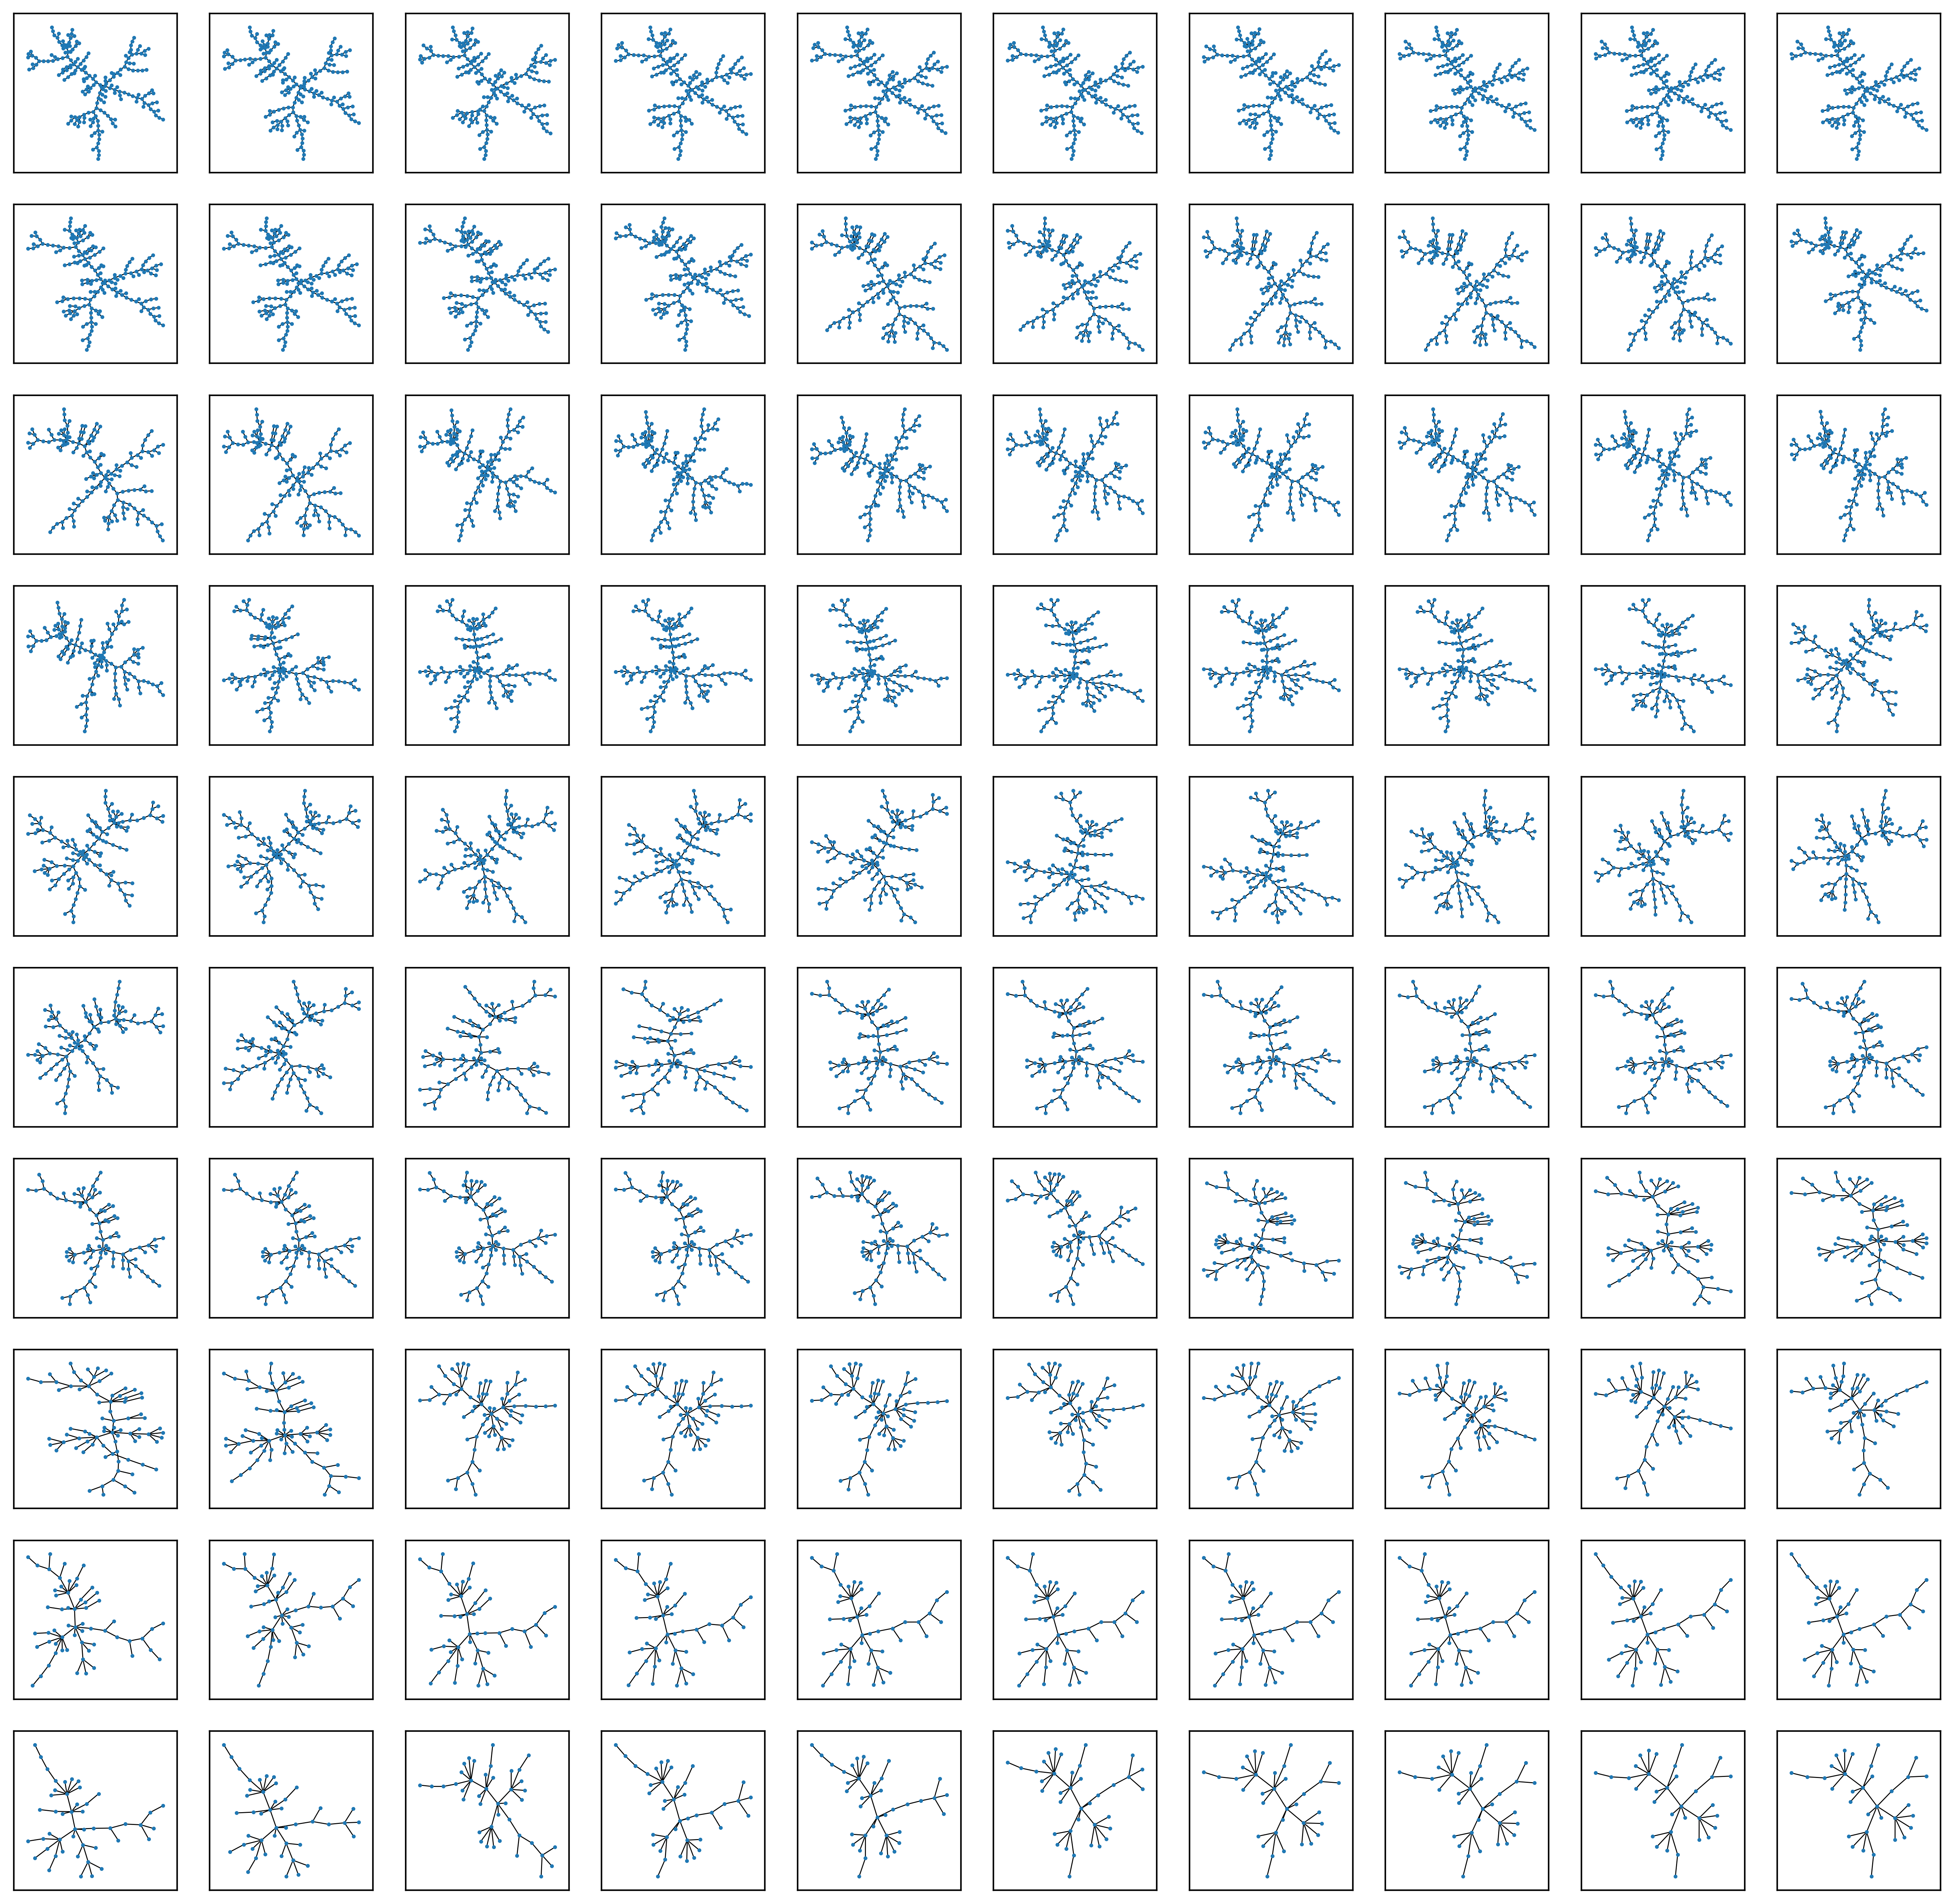

In [4]:
fig=plt.figure(dpi=400,figsize=(18,18))
for InterID in range(1,len(RG_Flow)):
    print(InterID)
    plt.subplot(10, 10, InterID)
    nx.draw_networkx(RG_Flow[InterID-1],pos=nx.kamada_kawai_layout(RG_Flow[InterID-1]) , with_labels=False,node_size=1, width=0.5)
    plt.draw()

In [5]:
Mean_K_S_Static=KS_Analysis(RG_Flow)

In [10]:
X_Initial=nx.random_tree(200)
nx.set_edge_attributes(X_Initial, 1, 'number')
size = X_Initial.number_of_edges()  
alpha = 2.0  
weights = np.random.pareto(alpha, size) + 1

for i, (u, v) in enumerate(X_Initial.edges()):
    X_Initial[u][v]['weight'] = weights[i]

Loc = nx.kamada_kawai_layout(X_Initial)
Loc=Loc.values()
Loc=list(Loc)
Loc=np.array(Loc)
RG_Flow,Tracked_ID_list=Renormalization_Flow(X_Initial,100,20,"Cauchy_Kernel","Structure", Weighted=True)

['KNN search costs-', 0.0010018348693847656]
['There are', 198, 'macro-units after', 1, 'times of renormalization']
['The', 1, 'time of renormalization costs-', 0.1730048656463623]
['KNN search costs-', 0.0010020732879638672]
['There are', 195, 'macro-units after', 2, 'times of renormalization']
['The', 2, 'time of renormalization costs-', 0.20999836921691895]
['KNN search costs-', 0.0]
['There are', 195, 'macro-units after', 3, 'times of renormalization']
['The', 3, 'time of renormalization costs-', 0.2779996395111084]
['KNN search costs-', 0.0]
['There are', 194, 'macro-units after', 4, 'times of renormalization']
['The', 4, 'time of renormalization costs-', 0.22214436531066895]
['KNN search costs-', 0.0009987354278564453]
['There are', 194, 'macro-units after', 5, 'times of renormalization']
['The', 5, 'time of renormalization costs-', 0.21258306503295898]
['KNN search costs-', 0.0]
['There are', 192, 'macro-units after', 6, 'times of renormalization']
['The', 6, 'time of renormaliz

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


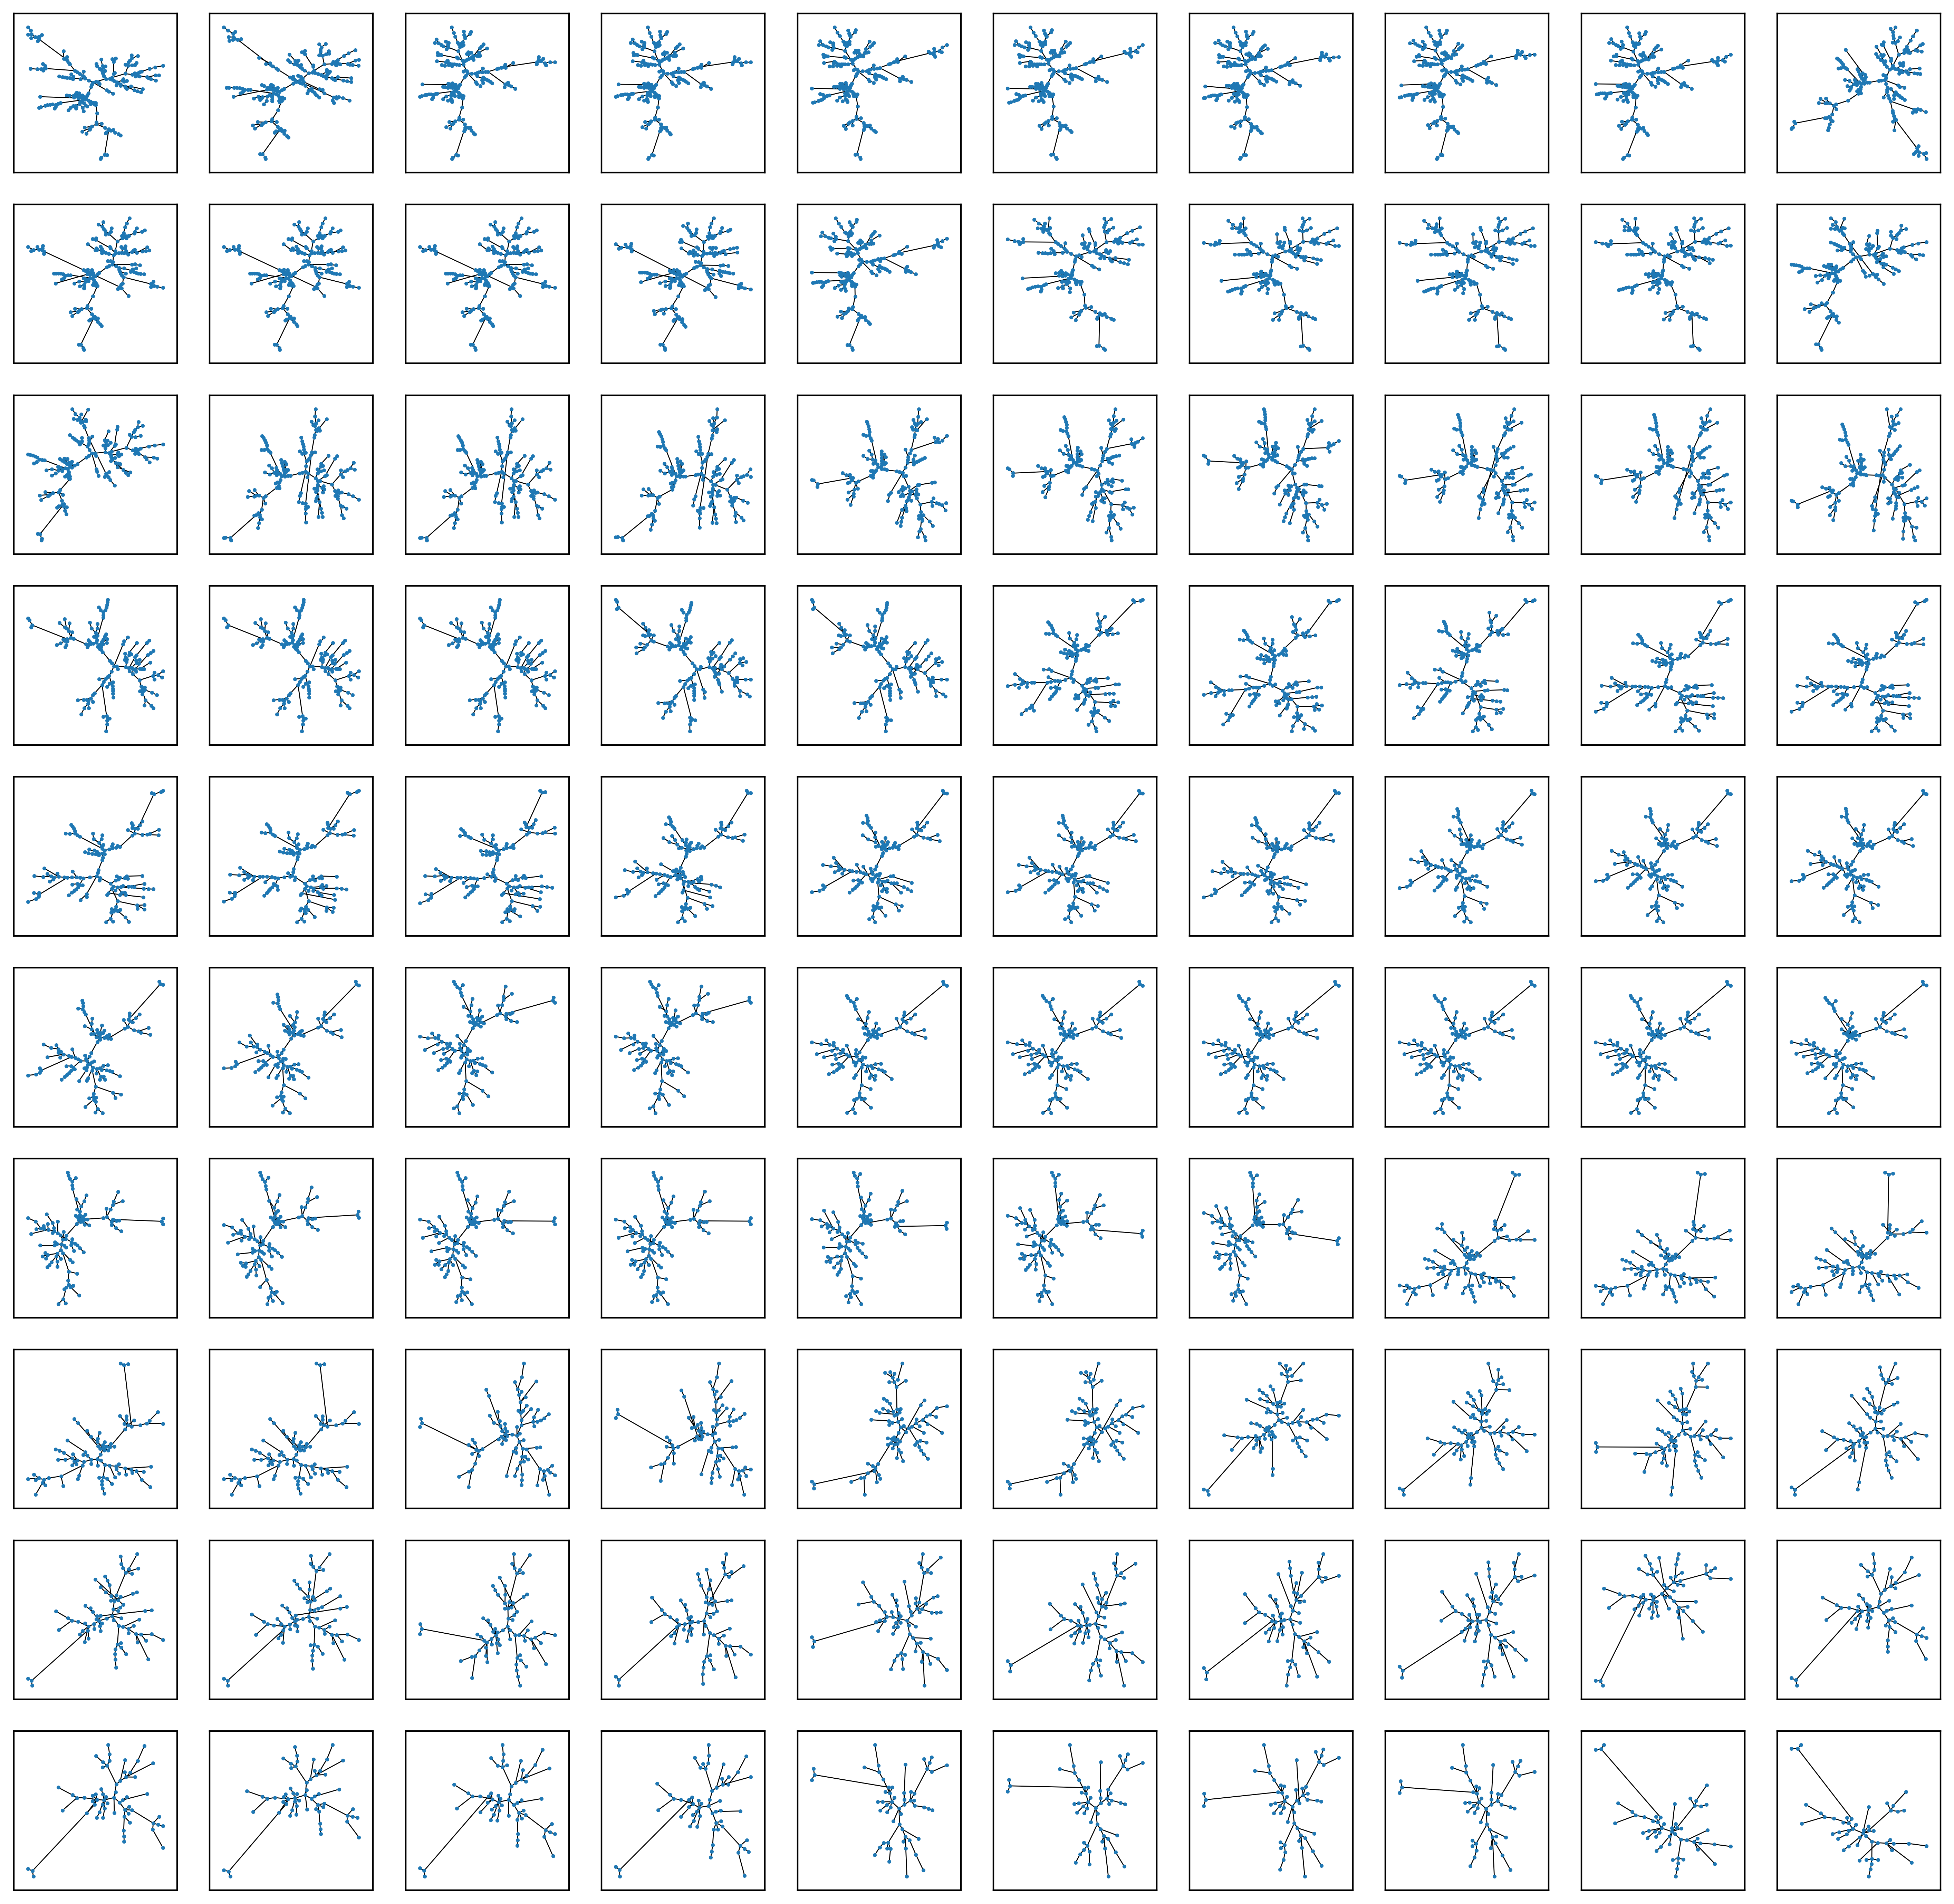

In [11]:
fig=plt.figure(dpi=400,figsize=(18,18))
for InterID in range(1,len(RG_Flow)):
    print(InterID)
    plt.subplot(10, 10, InterID)
    nx.draw_networkx(RG_Flow[InterID-1],pos=nx.kamada_kawai_layout(RG_Flow[InterID-1]) , with_labels=False,node_size=1, width=0.5)
    plt.draw()

In [12]:
Mean_K_S_Static=KS_Analysis(RG_Flow)